### And welcome to Week 4, Day 3 - more LangGraph..

In [ ]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama
from typing import TypedDict


In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [9]:
from langchain.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()
search.invoke("What is capital of France?")

"Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and attractive cities, famed for its gastronomy, haute couture, painting, literature, and intellectual community. Learn more about Paris in this article. Paris, being the culinary capital of France, has a gastronomic scene second to none. Here are five essential meals to enjoy while you're in Paris, and each restaurant listed provides a quintessential taste of French cuisine. Croissant. A flaky, buttery French pastry is the perfect start to the day. France's capital city lies in the northern part of the country. Believe it or not, it's actually farther north than Montreal! By high-speed train, Paris is just two-and-a-half hours from London, three hours from Brussels, and roughly two hours from Lyon or Bordeaux. France: The capital of France is Paris. Paris is not only the political capital but also a major cultural and economic center. 

### Now here is a LangChain wrapper class for converting functions into Tools

In [10]:
from langchain.agents import Tool

tool_search = Tool(
        name="search",
        func=search.invoke,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [11]:
tool_search.invoke("What is the capital of France?")

"Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and attractive cities, famed for its gastronomy, haute couture, painting, literature, and intellectual community. Learn more about Paris in this article. France, a country of northwestern Europe, is historically and culturally among the most important countries in the Western world. It has also played a highly significant role in international affairs for centuries. Its capital is Paris, one of the most important cultural and commercial centers in the world. Paris, the capital of France, is located in the north-central portion of the country. It constitutes one of the départements of the Île-de-France administrative region and is France's most important centre of commerce and culture. The city is home to the Eiffel Tower, one of the world's premier tourist attractions, which opened to the public on May 15, 1889. Paris (French pronunciat

### And now let's write a tool ourselves

We'll pick a familiar one

In [16]:
def push(text: str):
    """Send a push notification to the user"""
    print(f"Push Notification '{text}' sent successfully!!!")

In [17]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

Push Notification 'Hello, me' sent successfully!!!


### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [18]:
tools = [tool_search, tool_push]

In [19]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [20]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [21]:
# This is different:

llm = ChatOllama(base_url="http://localhost:11434", model="llama3.2:1b")
llm_with_tools = llm.bind_tools(tools)

In [22]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [24]:
# Step 4: Create Edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

ValueError: Branch with name `tools_condition` already exists for node `chatbot`

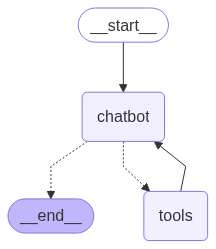

In [25]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [26]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [27]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

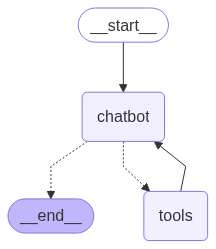

In [28]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOllama(base_url="http://localhost:11434", model="llama3.2:1b")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='HI there', additional_kwargs={}, response_metadata={}, id='8fdc3d2a-b21d-47f9-b88e-73bb8b2cd01d')]}
{'messages': [HumanMessage(content='HI there', additional_kwargs={}, response_metadata={}, id='8fdc3d2a-b21d-47f9-b88e-73bb8b2cd01d'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-13T15:19:47.377900656Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3808132953, 'load_duration': 1557899557, 'prompt_eval_count': 217, 'prompt_eval_duration': 1073632440, 'eval_count': 23, 'eval_duration': 1175516156, 'model_name': 'llama3.2:1b'}, id='run--aaf4dd29-71c9-4ce9-b8b6-32a63229ff2a-0', tool_calls=[{'name': 'search', 'args': {'__arg1': 'Python'}, 'id': '68c05639-d649-4861-864d-880e44b8cdb1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 23, 'total_tokens': 240}), ToolMessage(content='The official home of the Python Programming Language. Maintaining our ever-ev

In [30]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='HI there', additional_kwargs={}, response_metadata={}, id='8fdc3d2a-b21d-47f9-b88e-73bb8b2cd01d'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-13T15:19:47.377900656Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3808132953, 'load_duration': 1557899557, 'prompt_eval_count': 217, 'prompt_eval_duration': 1073632440, 'eval_count': 23, 'eval_duration': 1175516156, 'model_name': 'llama3.2:1b'}, id='run--aaf4dd29-71c9-4ce9-b8b6-32a63229ff2a-0', tool_calls=[{'name': 'search', 'args': {'__arg1': 'Python'}, 'id': '68c05639-d649-4861-864d-880e44b8cdb1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 23, 'total_tokens': 240}), ToolMessage(content='The official home of the Python Programming Language. Maintaining our ever-evolving Python codebase poses an intricate challenge: how do we make updates to reflect the changing rules and regul

In [31]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='HI there', additional_kwargs={}, response_metadata={}, id='8fdc3d2a-b21d-47f9-b88e-73bb8b2cd01d'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-13T15:19:47.377900656Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3808132953, 'load_duration': 1557899557, 'prompt_eval_count': 217, 'prompt_eval_duration': 1073632440, 'eval_count': 23, 'eval_duration': 1175516156, 'model_name': 'llama3.2:1b'}, id='run--aaf4dd29-71c9-4ce9-b8b6-32a63229ff2a-0', tool_calls=[{'name': 'search', 'args': {'__arg1': 'Python'}, 'id': '68c05639-d649-4861-864d-880e44b8cdb1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 23, 'total_tokens': 240}), ToolMessage(content='The official home of the Python Programming Language. Maintaining our ever-evolving Python codebase poses an intricate challenge: how do we make updates to reflect the changing rules and regu

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [32]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

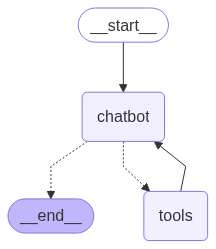

In [33]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOllama(base_url="http://localhost:11434", model="llama3.2:1b")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='e2f952a8-dc5d-4767-b5fe-1d5d7a7dea95')]}
{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='e2f952a8-dc5d-4767-b5fe-1d5d7a7dea95'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-13T15:21:44.772712549Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1772564880, 'load_duration': 15531775, 'prompt_eval_count': 216, 'prompt_eval_duration': 769991291, 'eval_count': 18, 'eval_duration': 986510461, 'model_name': 'llama3.2:1b'}, id='run--e4e36cc5-c7f0-40d0-abe0-af6289175aaa-0', tool_calls=[{'name': 'search', 'args': {'__arg1': 'hello'}, 'id': 'de2f7370-053a-4153-8d5a-18997144a079', 'type': 'tool_call'}], usage_metadata={'input_tokens': 216, 'output_tokens': 18, 'total_tokens': 234}), ToolMessage(content='HELLO! brings you the latest celebrity & royal news from the UK & around the world, maga